In [3]:
# Heart Disease Classification using Decision Tree
# Dataset: UCI Heart Disease

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

In [8]:
# Load the UCI Heart Disease dataset
print("Loading UCI Heart Disease dataset...")
try:
    # Try standard UCI heart disease file format
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
    column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 
                    'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
    df = pd.read_csv(url, names=column_names)
except:
    try:
        # Try alternative format (Kaggle version)
        df = pd.read_csv('C:\Course\Heart Disease UCI Dataset\DATA\heart_disease_uci.csv')
        print("Loaded dataset from 'heart.csv'")
    except:
        print("Error loading dataset. Please ensure the dataset file is available.")
        print("You may need to download it from: https://www.kaggle.com/ronitf/heart-disease-uci")
        exit()

Loading UCI Heart Disease dataset...
Loaded dataset from 'heart.csv'


In [9]:
# Display basic information about the dataset
print("\n--- Dataset Information ---")
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())


--- Dataset Information ---
Dataset shape: (920, 16)

First 5 rows:
   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect   

In [10]:
# Check for missing values
print("\nChecking for missing values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values found")


Checking for missing values:
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
dtype: int64


In [11]:
# Handle any '?' values which might be present in some versions of the dataset
for column in df.columns:
    if df[column].dtype == object:
        df[column] = pd.to_numeric(df[column], errors='coerce')

In [12]:
# Handle any remaining missing values (if any)
if df.isnull().sum().sum() > 0:
    print("\nReplacing missing values with median for numerical columns")
    for col in df.columns:
        df[col].fillna(df[col].median(), inplace=True)


Replacing missing values with median for numerical columns


In [14]:
print(df.columns)

Index(['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs',
       'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'],
      dtype='object')


In [15]:
# Ensure num is binary (some versions have multiple classes)
if df['num'].nunique() > 2:
    print("\nConverting num to binary classification task")
    # If num has values > 1, convert to binary (0: no disease, 1: disease)
    df['num'] = df['num'].apply(lambda x: 1 if x > 0 else 0)


Converting num to binary classification task


In [16]:
# Exploratory Data Analysis
print("\n--- Exploratory Data Analysis ---")


--- Exploratory Data Analysis ---


In [17]:
# Create a directory for saving figures if it doesn't exist
import os
if not os.path.exists('figures'):
    os.makedirs('figures')

num distribution: No Disease: 411, Disease: 509


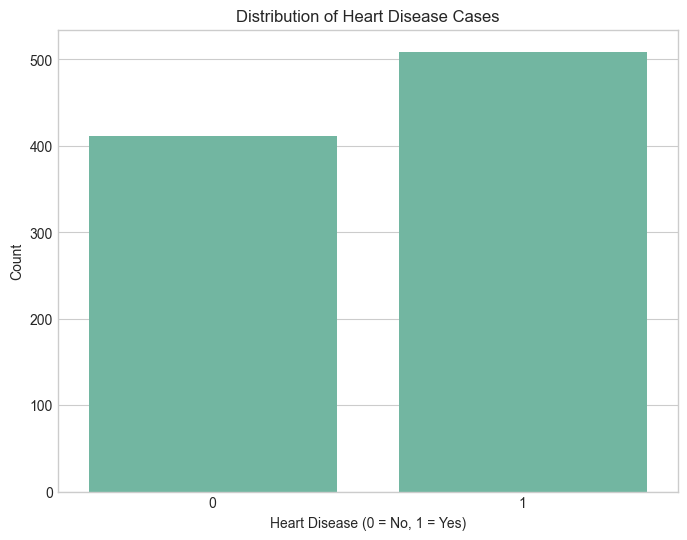

In [18]:
# Distribution of num variable
plt.figure(figsize=(8, 6))
num_counts = df['num'].value_counts()
sns.countplot(x='num', data=df)
plt.title('Distribution of Heart Disease Cases')
plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.savefig('figures/dt_num_distribution.png')
print(f"num distribution: No Disease: {num_counts[0]}, Disease: {num_counts[1]}")

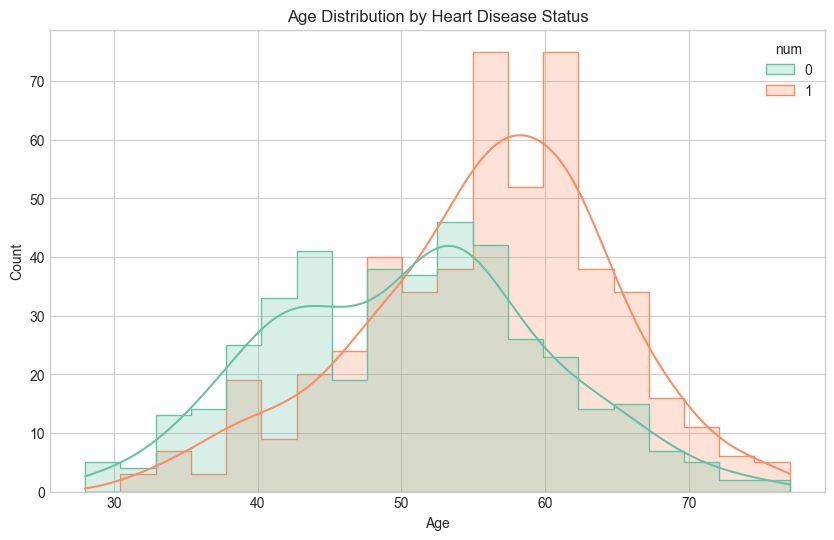

In [19]:
# Age distribution by heart disease status
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='num', element='step', kde=True, bins=20)
plt.title('Age Distribution by Heart Disease Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.savefig('figures/dt_age_distribution.png')

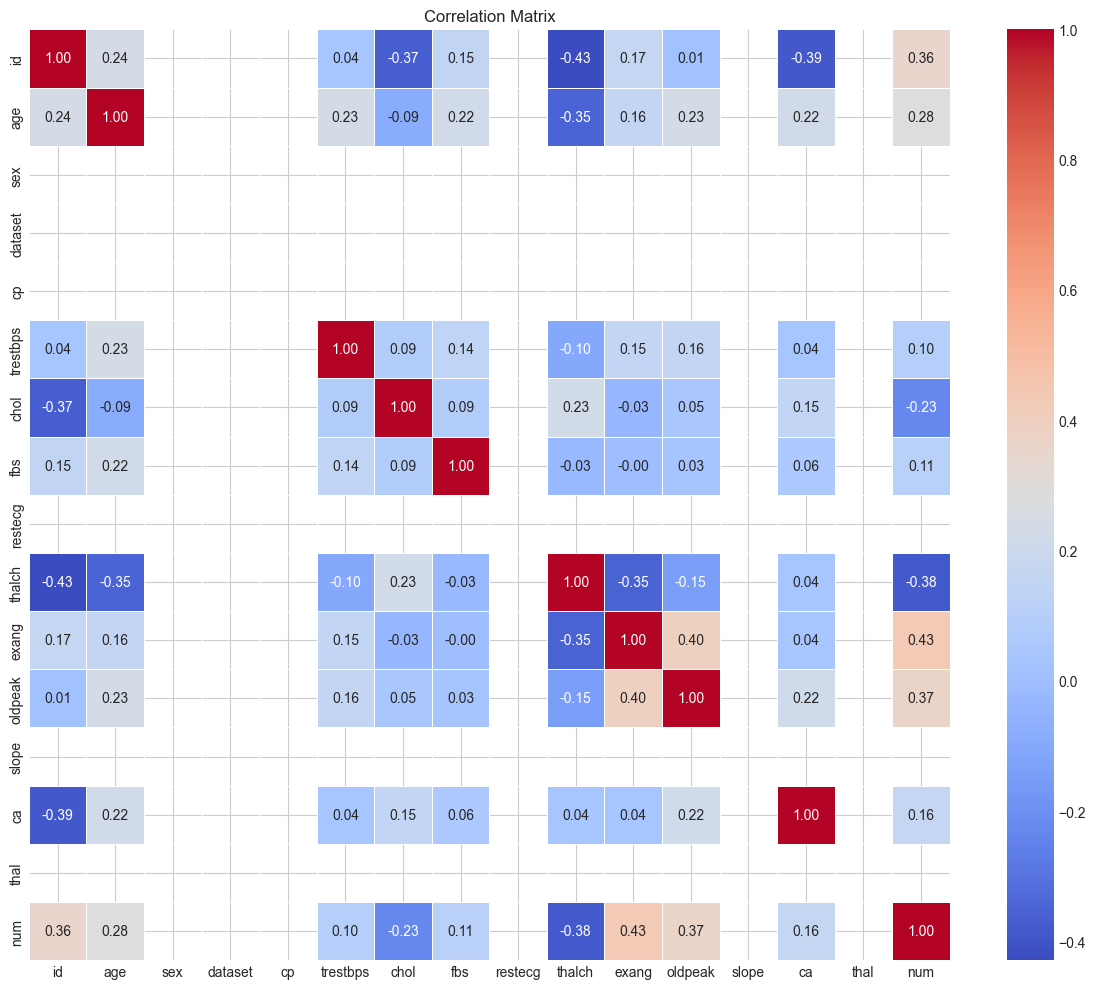

In [20]:
# Correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('figures/dt_correlation_matrix.png')

In [21]:
# Data Preparation
print("\n--- Data Preparation ---")


--- Data Preparation ---


In [22]:
# Split features and num
X = df.drop('num', axis=1)
y = df['num']

In [23]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (736, 15)
Testing set shape: (184, 15)


In [24]:
# Model Development
print("\n--- Decision Tree Model Development ---")


--- Decision Tree Model Development ---


In [25]:
# Create a pipeline with scaling and Decision Tree
dt_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),  
    ('dt', DecisionTreeClassifier(random_state=42))
])

In [26]:
# Define hyperparameters to tune
param_grid = {
    'dt__criterion': ['gini', 'entropy'],
    'dt__max_depth': [None, 3, 5, 7, 10],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4],
    'dt__ccp_alpha': [0.0, 0.01, 0.02, 0.03, 0.05]  # Cost-complexity pruning parameter
}

In [27]:
# Use GridSearchCV to find optimal hyperparameters
print("Performing GridSearchCV to find optimal hyperparameters...")
grid_search = GridSearchCV(dt_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

Performing GridSearchCV to find optimal hyperparameters...


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'dt__ccp_alpha': [0.0, 0.01, 0.02, 0.03, 0.05],
                         'dt__criterion': ['gini', 'entropy'],
                         'dt__max_depth': [None, 3, 5, 7, 10],
                         'dt__min_samples_leaf': [1, 2, 4],
                         'dt__min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [28]:
# Best parameters and score
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")


Best parameters: {'dt__ccp_alpha': 0.02, 'dt__criterion': 'gini', 'dt__max_depth': None, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2}
Best cross-validation score: 0.8464


In [29]:
# Get the best model
best_dt_model = grid_search.best_estimator_

In [30]:
# Model Evaluation
print("\n--- Model Evaluation ---")


--- Model Evaluation ---


In [31]:
# Make predictions
y_pred = best_dt_model.predict(X_test)
y_pred_proba = best_dt_model.predict_proba(X_test)[:, 1]

In [32]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8587


In [33]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.78      0.83        82
           1       0.84      0.92      0.88       102

    accuracy                           0.86       184
   macro avg       0.86      0.85      0.85       184
weighted avg       0.86      0.86      0.86       184



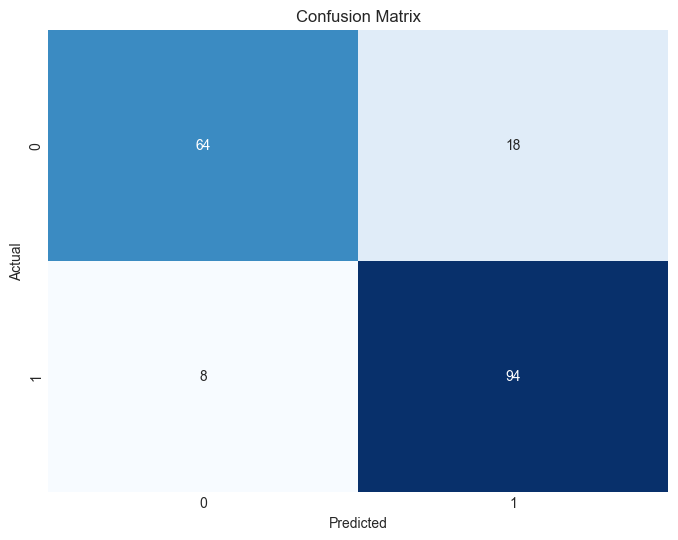

In [34]:
# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('figures/dt_confusion_matrix.png')

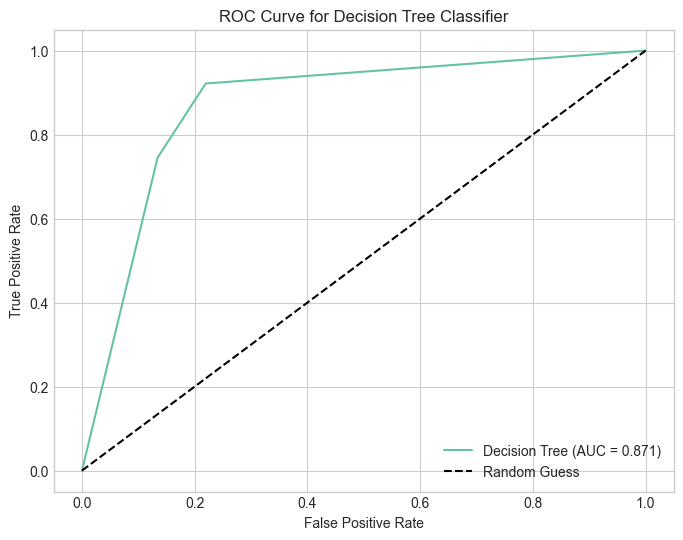

In [35]:
# ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Decision Tree (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree Classifier')
plt.legend(loc='lower right')
plt.savefig('figures/dt_roc_curve.png')

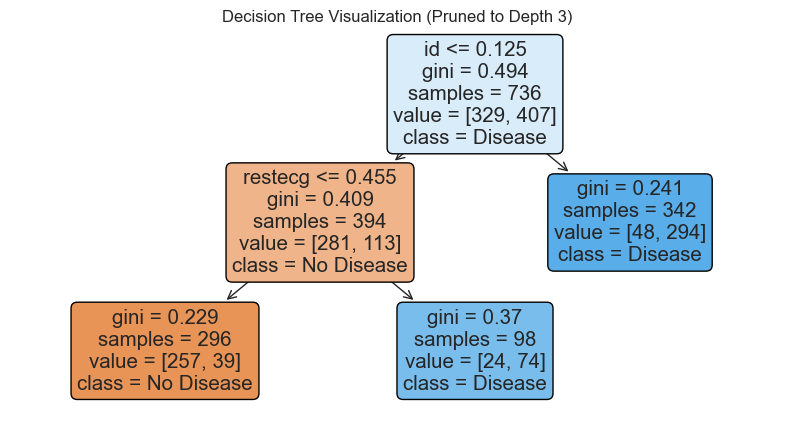

In [44]:
# Visualize the Decision Tree
plt.figure(figsize=(10, 5))
dt = best_dt_model.named_steps['dt']
plot_tree(dt, 
          feature_names=X.columns, 
          class_names=['No Disease', 'Disease'],
          filled=True, 
          rounded=True,
          max_depth=3)  # Limiting depth for visualization
plt.title('Decision Tree Visualization (Pruned to Depth 3)')
plt.savefig('figures/dt_visualization.png', dpi=300, bbox_inches='tight')

     Feature  Importance
0         id    0.328804
13        ca    0.101087
1        age    0.000000
2        sex    0.000000
3    dataset    0.000000
4         cp    0.000000
5   trestbps    0.000000
6       chol    0.000000
7        fbs    0.000000
8    restecg    0.000000
9     thalch    0.000000
10     exang    0.000000
11   oldpeak    0.000000
12     slope    0.000000
14      thal    0.000000


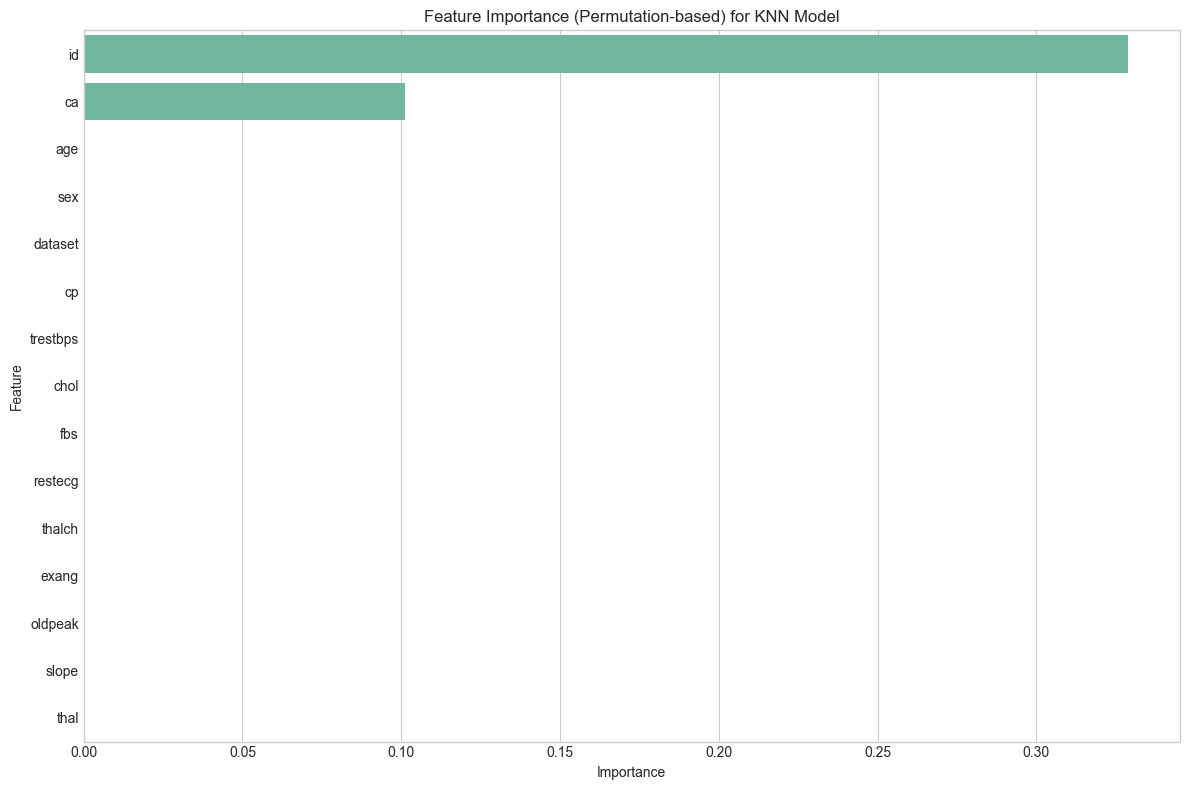

In [49]:
# Create a feature importance proxy using permutation importance
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(best_dt_model, X_test, y_test, n_repeats=10, random_state=42)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance (Permutation-based) for KNN Model')
plt.tight_layout()
plt.savefig('figures/knn_feature_importance.png')
print(feature_importance)

In [50]:
# Cost Complexity Pruning Analysis
path = DecisionTreeClassifier(random_state=42).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [51]:
# Create trees with different ccp_alpha values
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

In [52]:
# Remove the last element which has only the root node
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

In [53]:
# Calculate accuracy on training and testing sets
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

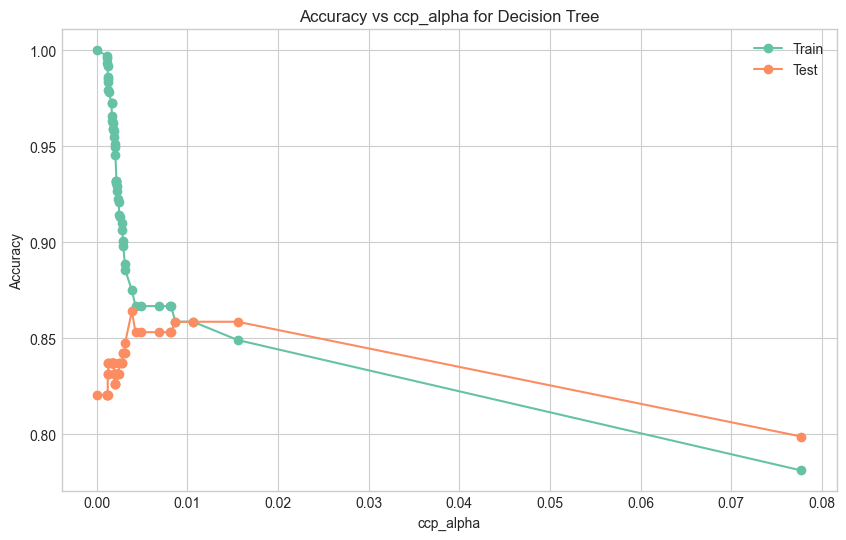

In [54]:
# Plot accuracy vs alpha
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, train_scores, marker='o', label='Train')
plt.plot(ccp_alphas, test_scores, marker='o', label='Test')
plt.xlabel('ccp_alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy vs ccp_alpha for Decision Tree')
plt.legend()
plt.grid(True)
plt.savefig('figures/dt_ccp_alpha_analysis.png')

In [55]:
# Decision boundaries visualization (for selected features)
# Choose two most important features
top_features = feature_importance['Feature'].iloc[:2].tolist()

In [56]:
# Create a mesh grid of points to plot the decision boundary
plt.figure(figsize=(10, 8))
h = 0.02  # Step size in the mesh
x_min, x_max = X[top_features[0]].min() - 1, X[top_features[0]].max() + 1
y_min, y_max = X[top_features[1]].min() - 1, X[top_features[1]].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

<Figure size 1000x800 with 0 Axes>

In [57]:
# Create a reduced dataset with just the top two features
X_reduced = X[[top_features[0], top_features[1]]]
X_train_reduced = X_train[[top_features[0], top_features[1]]]
X_test_reduced = X_test[[top_features[0], top_features[1]]]

In [58]:
# Train a new decision tree on the reduced feature set
reduced_dt = DecisionTreeClassifier(
    random_state=42,
    criterion=grid_search.best_params_['dt__criterion'],
    max_depth=grid_search.best_params_['dt__max_depth'],
    min_samples_split=grid_search.best_params_['dt__min_samples_split'],
    min_samples_leaf=grid_search.best_params_['dt__min_samples_leaf'],
    ccp_alpha=grid_search.best_params_['dt__ccp_alpha']
)
reduced_dt.fit(X_train_reduced, y_train)

DecisionTreeClassifier(ccp_alpha=0.02, random_state=42)

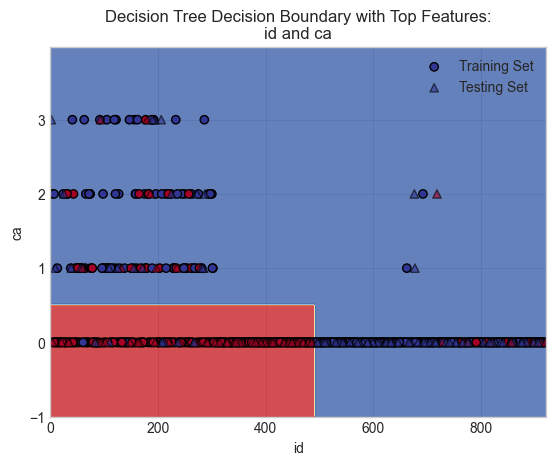

In [60]:
# Plot the decision boundary
Z = reduced_dt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)

# Plot the training points
plt.scatter(X_train_reduced[top_features[0]], X_train_reduced[top_features[1]], c=y_train, 
            edgecolors='k', cmap=plt.cm.RdYlBu, label='Training Set')
# Plot the testing points
plt.scatter(X_test_reduced[top_features[0]], X_test_reduced[top_features[1]], c=y_test, 
            marker='^', edgecolors='k', cmap=plt.cm.RdYlBu, alpha=0.6, label='Testing Set')
plt.xlabel(top_features[0])
plt.ylabel(top_features[1])
plt.title(f'Decision Tree Decision Boundary with Top Features:\n{top_features[0]} and {top_features[1]}')
plt.legend()
plt.savefig('figures/dt_decision_boundary.png')

In [61]:
# Save the best model
import joblib
joblib.dump(best_dt_model, 'heart_disease_dt_model.pkl')
print("\nBest Decision Tree model saved as 'heart_disease_dt_model.pkl'")


Best Decision Tree model saved as 'heart_disease_dt_model.pkl'


In [62]:
print("\n--- Summary ---")
print(f"Model: Decision Tree with optimal parameters: {grid_search.best_params_}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"AUC-ROC Score: {roc_auc:.4f}")
print("Figures saved in the 'figures' directory")


--- Summary ---
Model: Decision Tree with optimal parameters: {'dt__ccp_alpha': 0.02, 'dt__criterion': 'gini', 'dt__max_depth': None, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2}
Test Accuracy: 0.8587
AUC-ROC Score: 0.8710
Figures saved in the 'figures' directory
